## QUESTION 1

### Question1A

In [1]:
import csv
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


df_ratings = pd.read_csv('ratings.csv')
df_movies = pd.read_csv('movies.csv')

user_id = []
movie_id = []
ratings = []

rat_mat = df_ratings.pivot_table(index=['userId'], values=['rating'], columns=['movieId'], fill_value=0).values
rat_pv = df_ratings.pivot_table(index=['userId'], values=['rating'], columns=['movieId'], fill_value=0)
total_available_rating = len(df_ratings)
user_num = rat_mat.shape[0]
movie_num = rat_mat.shape[1]
print('Number of Users:', user_num)
print('Number of Rated Movies:', movie_num)
total_possible_rating = user_num * movie_num
print('Sparsity =', float(total_available_rating) / total_possible_rating)

Number of Users: 610
Number of Rated Movies: 9724
Sparsity = 0.016999683055613623


### Question1B: 
Answer: Based on the histogram, it appears that a significant proportion of ratings fall within the range of 3.0 to 4.0. This suggests that users may have a tendency to rate movies more favorably overall, and that the majority of movies in this dataset have received positive ratings.

0.5 5.0


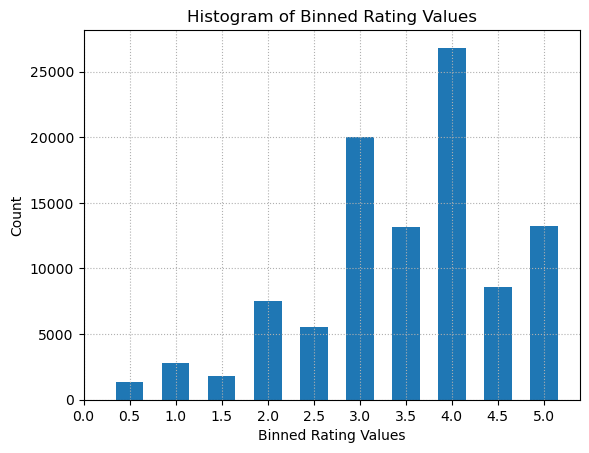

In [2]:
userIDs = df_ratings['userId'].values
movies = df_ratings['movieId'].values
Rating = df_ratings['rating'].values
min_rating = Rating.min()
max_rating = Rating.max()
print(min_rating, max_rating)

uni_values, uni_indices = np.unique(Rating, return_inverse=True)
plt.bar(uni_values, np.bincount(uni_indices), width=0.3)
locs, labels = plt.xticks()  
plt.grid(linestyle=':')
plt.xticks(np.arange(0,5.5,0.5),rotation=0)
plt.xlabel('Binned Rating Values')
plt.ylabel('Count')
plt.title('Histogram of Binned Rating Values')
plt.show()

### Question1C

[215 110  52 ...   1   1   1]


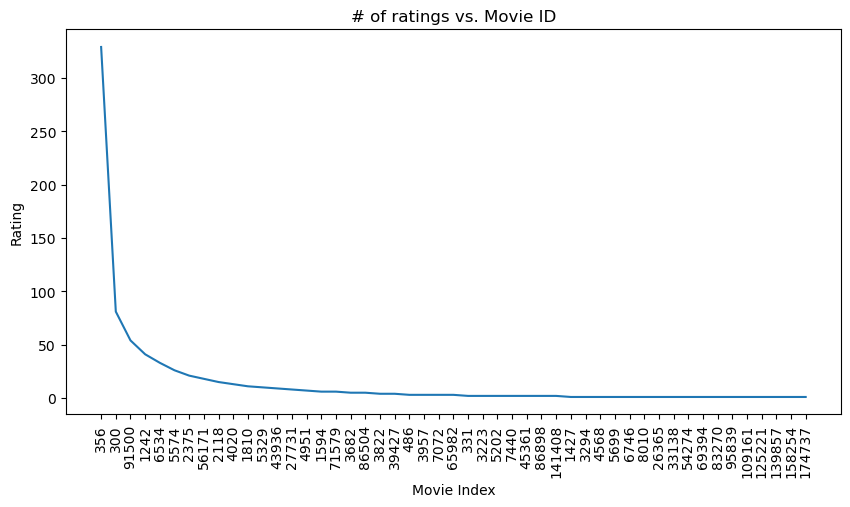

In [3]:
rat_pv = df_ratings.pivot_table(index=['userId'], values=['rating'], columns=['movieId'], fill_value=0)
Comment_or_Not = rat_mat > 0

movie_idx = list(rat_pv.columns.get_level_values(1))
movies_rating = np.sum(Comment_or_Not, 0)

sorted_counts = [(counts, idx) for counts, idx in sorted(zip(movies_rating, movie_idx), 
                                                         key=lambda pair: pair[0], reverse = True)]

sorted_counts = sorted_counts[::200]
_x = [str(i[1]) for i in sorted_counts]
_y = [i[0] for i in sorted_counts]
print(movies_rating)


plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(_x, _y)
plt.xticks(rotation=90)
plt.xlabel('Movie Index')
plt.ylabel('Rating')
plt.title('# of ratings vs. Movie ID')
plt.show()

### Question1D

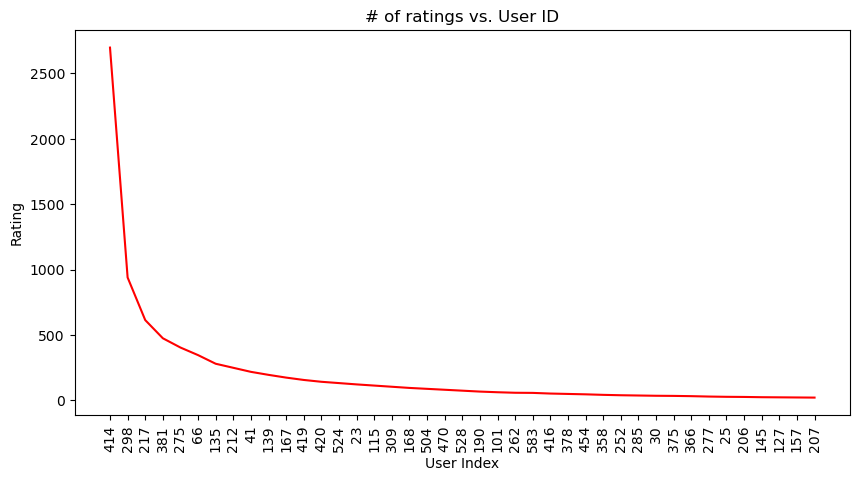

In [4]:
Comment_or_Not = rat_mat > 0
users_rating = np.sum(Comment_or_Not, 1)

user_idx = list(rat_pv.index)

user_sorted_counts = [(counts, idx) for counts, idx in sorted(zip(users_rating, user_idx), 
                                                         key=lambda pair: pair[0], reverse = True)]

user_sorted_counts = user_sorted_counts[::15]
__x = [str(i[1]) for i in user_sorted_counts]
__y = [i[0] for i in user_sorted_counts]

plt.plot(__x, __y, color = 'r')
plt.xlabel('User Index')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.title('# of ratings vs. User ID')
plt.show()

### Question1E

Answer: The findings from the Figure in Question 1C indicate that a small group of movies garnered the majority of ratings, while the majority of movies received only a few ratings. This suggests that the rating matrix R is sparsely populated, and that to prevent overfitting and erroneous connections, substantial regularization may be required during the recommendation process. Furthermore, for the "popular" movies with a significant number of ratings, the recommendation system will have access to more reliable data points to base its calculations on, thereby enhancing the likelihood of accurate Predicting whether or not these movies should be recommended to a particular user.

### Question1F

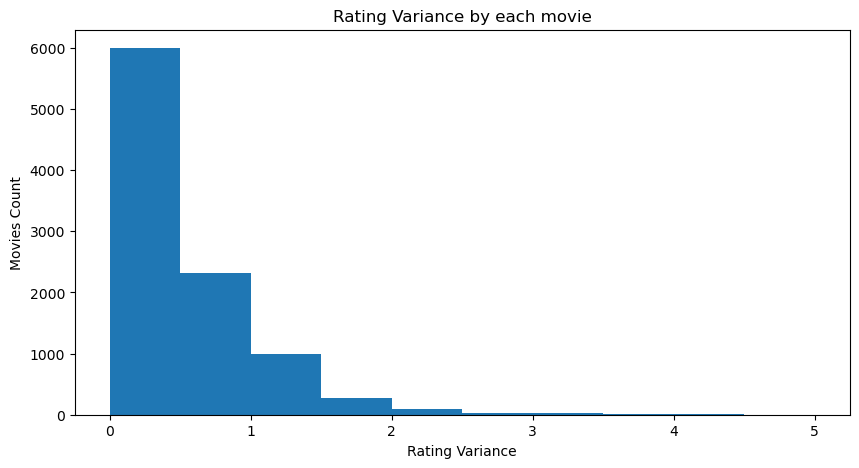

In [5]:
movies_dict = {}

for i in range(len(userIDs)):
    if (movies[i] not in movies_dict.keys()):
        movies_dict[movies[i]] = [(userIDs[i], Rating[i])]
    else:
        movies_dict[movies[i]].append((userIDs[i], Rating[i]))
        

variances = []
for movie in movies_dict.keys():
    temp_vars = []
    for i in movies_dict[movie]:
        temp_vars.append(i[1])
    variances.append(np.var(np.asarray(temp_vars)))
    
plt.hist(variances, bins=np.arange(0, 5.5, 0.5))
plt.xlabel("Rating Variance")
plt.title("Rating Variance by each movie")
plt.ylabel("Movies Count")
plt.show()  

### Question 2A

$\mu_u = \frac{\sum_{k \in{I_u}}r_{uk}}{length(I_u)}$

### Question 2B

Answer: The quantity ${I_u∩I_v}$ denotes the indices of movies that have received ratings from both user u and user v. Due to the sparsity of the rating matrix R, it is highly probable that ${I_u∩I_v=∅}$ because it is unlikely that both users viewed and rated the same movies. Given the vast number of movies in the dataset, it is entirely plausible that user u and user v did not view any of the same movies. Moreover, even if they viewed some of the same movies, it is feasible that one user rated the movie while the other did not, resulting in a value of 0.

## Question 3

Answer: By mean-centering the ratings, we can minimize the impact of outliers and mitigate prediction bias. This approach enables us to eliminate the impact of users who tend to give excessively high or low ratings, which are typically subjective and prone to errors. Consequently, the mean-centered ratings lead to more precise predictions. In essence, mean-centering compensates for and eliminates the impact of individual rating styles on the dataset.

## Question 4

In [6]:
from surprise import KNNBasic
from surprise.model_selection.split import KFold
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader


k_choices = range(2, 101, 2)
models = [
    KNNBasic(k=k, sim_options={'name': 'pearson'}, verbose=False)
    for k in k_choices
]

kfold = KFold(n_splits=10, random_state=0)

reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)


results = []
for index, model in enumerate(models):
#     print('iteration: {}/{}'.format(index + 1, len(models)))
    result = cross_validate(model, data, cv=kfold, verbose=False, n_jobs=-1)
    results.append(result)

rmse = [np.mean(result['test_rmse']) for result in results]
mae = [np.mean(result['test_mae']) for result in results]

plt.plot(k_choices, rmse, label='RMSE')
plt.plot(k_choices, mae, label='MAE')
plt.xlabel('k')
plt.ylabel('Error')
plt.legend()
plt.show()


KeyboardInterrupt: 

## Question 5

In [ ]:
# a table, each row is a k, columns are [k, RMSE, MAE]
table = pd.DataFrame(columns=['k', 'RMSE', 'MAE'])
table['k'] = k_choices
table['RMSE'] = rmse
table['MAE'] = mae

In [ ]:
# find the best k
best_k = 10

# shoow the rmse and mae of the best k
print(table.loc[table['k'] == best_k])



## Question 6

In [16]:
# split the dataset
def split_data(data, condition):
    return list(np.unique(data.loc[condition]['movieId']))

df_ratings['count'] = df_ratings.groupby('movieId')['rating'].transform('count')
df_ratings['mean'] = df_ratings.groupby('movieId')['rating'].transform('mean')
df_ratings['std'] = df_ratings.groupby('movieId')['rating'].transform('std')
df_ratings['var'] = df_ratings.groupby('movieId')['rating'].transform('var')

# split the dataset
popular_movies_mask = split_data(df_ratings, df_ratings['count'] > 2)
unpopular_movies_mask = split_data(df_ratings, df_ratings['count'] <= 2)
high_var_movies_mask = split_data(df_ratings, df_ratings['var'] > 1)

popular_movies_df = df_ratings[df_ratings['movieId'].isin(popular_movies_mask)]
unpopular_movies_df = df_ratings[df_ratings['movieId'].isin(unpopular_movies_mask)]
high_var_movies_df = df_ratings[df_ratings['movieId'].isin(high_var_movies_mask)]

In [ ]:
from surprise import KNNBasic
# use trimed data
trims = [
    popular_movies_df,
    unpopular_movies_df,
    high_var_movies_df
]

trim_labels = [
    'popular',
    'unpopular',
    'high_var'
]

# ks
k_choices = range(2, 101, 2)

# models
models = [
    KNNBasic(k=k, sim_options={'name': 'pearson'}, verbose=False)
    for k in k_choices
]

for _itr, trim in enumerate(trims):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(trim[['userId', 'movieId', 'rating']], reader)
    # run the model
    results = []
    for index, model in enumerate(models):
#         print('iteration: {}/{}'.format(index + 1, len(models)))
        result = cross_validate(model, data, cv=kfold, verbose=False, n_jobs=-1)
        results.append(result)
    # get the results
    rmse = [np.mean(result['test_rmse']) for result in results]
    mae = [np.mean(result['test_mae']) for result in results]
    # plot the results
    plt.plot(k_choices, rmse, label='RMSE')
    plt.plot(k_choices, mae, label='MAE')
    plt.xlabel('k')
    plt.ylabel('Error')
    plt.title('Trimming: {}'.format(trim_labels[_itr]))
    plt.legend()
    plt.show()
    # a table, each row is a k, columns are [k, RMSE, MAE]
    table = pd.DataFrame(columns=['k', 'RMSE', 'MAE'])
    table['k'] = k_choices
    table['RMSE'] = rmse
    table['MAE'] = mae
    # minimum rmse
    min_rmse = table.loc[table['RMSE'] == min(table['RMSE'])]
    print('Minimum RMSE: {}'.format(min_rmse))

In [13]:
from sklearn.metrics import roc_curve, auc

def get_roc_curve(model, data, threshold):
    # get the predictions
    predictions = model.test(data)
    # get the true labels
    y_true = [1 if p[2] >= threshold else 0 for p in predictions]
    # get the predicted labels
    y_pred = [1 if p[3] >= threshold else 0 for p in predictions]
    # get the false positive rate, true positive rate and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    # get the area under the curve
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


In [ ]:
# ROC AUC plots


# train_test_split
from surprise.model_selection import train_test_split

best_ks = [52, 42, 2, 54]

thresholds = [2.5, 3.0, 3.5, 4.0]

trims = [
df_ratings,
popular_movies_df,
unpopular_movies_df,
high_var_movies_df
]

trim_labels = [
'all',
'popular',
'unpopular',
'high_var'
]

# get the roc curve

# plot the roc curve
def plot_roc_curve(fpr, tpr, auc_score, label):
    plt.plot(fpr, tpr, label='{} (area = {:.2f})'.format(label, auc_score))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# get the roc curve for each threshold

res = []
for _itr, trim in enumerate(trims):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(trim[['userId', 'movieId', 'rating']], reader)
    # For the ROC plotting, split the dataset into 90% for training and 10% for validation
    trainset, testset = train_test_split(data, test_size=.1)
    # get the model
    model = KNNBasic(k=best_ks[_itr], sim_options={'name': 'pearson'}, verbose=False)
    model.fit(trainset)

    for threshold in thresholds:
        fpr, tpr, auc_score = get_roc_curve(model, testset, threshold)
        res.append([trim_labels[_itr], threshold, fpr, tpr, auc_score])


# 4*4 plot

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for _itr, r in enumerate(res):
    axs[_itr // 4, _itr % 4].plot(r[2], r[3], label='{} (area = {:.2f})'.format(r[0], r[4]))
    axs[_itr // 4, _itr % 4].plot([0, 1], [0, 1], 'k--')
    axs[_itr // 4, _itr % 4].set_xlabel('False Positive Rate')
    axs[_itr // 4, _itr % 4].set_ylabel('True Positive Rate')
    axs[_itr // 4, _itr % 4].set_title('ROC Curve' + ' (threshold = {})'.format(r[1]) + ' (trim = {})'.format(r[0]))
    axs[_itr // 4, _itr % 4].legend(loc='lower right')
plt.show()

> QUESTION 6: Within EACH of the 3 trimmed subsets in the dataset, design (train and
validate):A k-NN collaborative filter on the ratings of the movies (i.e Popular, Unpopular or High-Variance)and evaluate each of the three models’ performance using 10-fold cross validation:
• Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute
the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE
(Y-axis) against k (X-axis). Also, report the minimum average RMSE.
• Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These
thresholds are applied only on the ground truth labels in held-out validation set. For each of
the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in
this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds
can be condensed into one plot per trimming option yielding only 4 plots

## Question 7

- Please see the handwritten note.

## Question 8

### Question 8A NMF

In [ ]:
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from surprise.model_selection.split import KFold
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader

# NMF
k_choices =  [i for i in range(2,51,2)]
models = [
    NMF(n_factors=k, random_state=None, verbose=False, n_epochs = 50)
    for k in k_choices
]

kfold = KFold(n_splits=10, random_state=0)

reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)


results = []
for index, model in enumerate(models):
#     print('iteration: {}/{}'.format(index + 1, len(models)))
    result = cross_validate(model, data, cv=kfold, verbose=False, n_jobs=-1, return_train_measures=True )
    results.append(result)
    
rmse = [np.mean(result['test_rmse']) for result in results]
mae = [np.mean(result['test_mae']) for result in results]

min_rmse_idx = rmse.index(min(rmse))
print('Minimum RMSE: k =%.0f RMSE=%.4f MAE= %.4f'%(k_choices[min_rmse_idx],rmse[min_rmse_idx],mae[min_rmse_idx]))



plt.plot(k_choices, rmse, label='RMSE')
plt.plot(k_choices, mae, label='MAE')
plt.xlabel('k')
plt.ylabel('Error')
plt.title('NMF Performance vs. # of components')
plt.legend()


# train_rmse = [np.mean(result['train_rmse']) for result in results]
# train_mae = [np.mean(result['train_mae']) for result in results]

###  Question 8B

> Question 8B: Use the plot from the previous part to find the optimal number of latent factors. Optimal
number of latent factors is the value of k that gives the minimum average RMSE or the
minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal
number of latent factors same as the number of movie genres?

- The best k value with the lowest RMSE is 18 with average cross validation RMSE of 0.9138 and MAE of 0.6953. According to the README file, there is a total of 18 avaliable genres (excluding "no genre listed"), which is the same as our optimal k value.

### Question 8C NMF on Trimmed Data

In [ ]:
# use trimed data
trims = [
    popular_movies_df,
    unpopular_movies_df,
    high_var_movies_df
]

trim_labels = [
    'popular',
    'unpopular',
    'high_var'
]

# ks
k_choices = range(2, 51, 2)

# models
models = [
    NMF(n_factors=k, random_state=None, verbose=False, n_epochs = 50)
    for k in k_choices
]

for _itr, trim in enumerate(trims):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(trim[['userId', 'movieId', 'rating']], reader)
    # run the model
    results = []
    for index, model in enumerate(models):
#         print('iteration: {}/{}'.format(index + 1, len(models)))
        result = cross_validate(model, data, cv=kfold, verbose=False, n_jobs=-1)
        results.append(result)
    # get the results
    rmse = [np.mean(result['test_rmse']) for result in results]
    mae = [np.mean(result['test_mae']) for result in results]
    # plot the results
    plt.plot(k_choices, rmse, label='RMSE')
    plt.plot(k_choices, mae, label='MAE')
    plt.xlabel('k')
    plt.ylabel('Error')
    plt.title('Trimming: {}'.format(trim_labels[_itr]))
    plt.legend()
    plt.show()
    # a table, each row is a k, columns are [k, RMSE, MAE]
    table = pd.DataFrame(columns=['k', 'RMSE', 'MAE'])
    table['k'] = k_choices
    table['RMSE'] = rmse
    table['MAE'] = mae
    # minimum rmse
    min_rmse = table.loc[table['RMSE'] == min(table['RMSE'])]
    print('Minimum RMSE: {}'.format(min_rmse))

In [ ]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
res = []
best_ks = [18, 16, 50, 48]
thresholds = [2.5, 3.0, 3.5, 4.0]

trims = [
  df_ratings,
  popular_movies_df,
  unpopular_movies_df,
  high_var_movies_df
]

trim_labels = [
  'all',
  'popular',
  'unpopular',
  'high_var'
]

for _itr, trim in enumerate(trims):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(trim[['userId', 'movieId', 'rating']], reader)
    # For the ROC plotting, split the dataset into 90% for training and 10% for validation
    trainset, testset = train_test_split(data, test_size=.1)
    # get the model
    model = NMF(n_factors=best_ks[_itr], random_state=0,verbose=False)
    model.fit(trainset)

    for threshold in thresholds:
        fpr, tpr, auc_score = get_roc_curve(model, testset, threshold)
        res.append([trim_labels[_itr], threshold, fpr, tpr, auc_score])


# 4*4 plot
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for _itr, r in enumerate(res):
    axs[_itr // 4, _itr % 4].plot(r[2], r[3], label='{} (area = {:.2f})'.format(r[0], r[4]))
    axs[_itr // 4, _itr % 4].plot([0, 1], [0, 1], 'k--')
    axs[_itr // 4, _itr % 4].set_xlabel('False Positive Rate')
    axs[_itr // 4, _itr % 4].set_ylabel('True Positive Rate')
    axs[_itr // 4, _itr % 4].set_title('ROC Curve' + ' (threshold = {})'.format(r[1]) + ' (trim = {})'.format(r[0]))
    axs[_itr // 4, _itr % 4].legend(loc='lower right')
plt.show()

## Question 9

In [ ]:
from sklearn.decomposition import NMF as sk_NMF
# NMF
sk_nmf = sk_NMF(n_components=20, init='random', random_state=0, max_iter = 1000)

U = sk_nmf.fit_transform(rat_mat)
VT = sk_nmf.components_

VT_df = pd.DataFrame(VT)
VT_df = VT_df.T
VT_df.shape

In [ ]:
def sort_f(x):
    return list(x.sort_values(ascending = False).index)

VT_sorted = VT_df.apply(lambda x: sort_f(x), axis = 0)
VT_sorted_top_10 = VT_sorted.loc[0:9:,:]
VT_sorted_top_10

In [ ]:
df_movies.loc[VT_sorted_top_10[3]]

In [ ]:
df_movies.loc[VT_sorted_top_10[15]]

> Question 9: Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

- According to our analysis, we can see that each column of V corresponds to some specific genres of movies. For example, the most of the movies from column 3 have the genre label Drama or Thriller, whereas most of the movies from column 15 have genre label of Musical, Fantasy, and Children. The latent factors each describes some attributes of the data. In the case of movies, the latent factors (i.e. the columns of V) act similarly to the genre of the movies but with some level of intercorrelation. If we increase the number of components, each column will have a more precise descriptive power and may be better able to divide movies by genre. 


## Question 10

### Question 10A

In [ ]:
# MF
k_choices =  [i for i in range(2,51,2)]
models = [
    NMF(n_factors=k, random_state=0, verbose=False, n_epochs = 50,biased = True)
    for k in k_choices
]

kfold = KFold(n_splits=10, random_state=0)

reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)


results = []
for index, model in enumerate(models):
    result = cross_validate(model, data, cv=kfold, verbose=False, n_jobs=-1)
    results.append(result)





rmse = [np.mean(result['test_rmse']) for result in results]
mae = [np.mean(result['test_mae']) for result in results]

min_rmse_idx = rmse.index(min(rmse))
print('Minimum RMSE: k =%.0f RMSE=%.4f MAE= %.4f'%(k_choices[min_rmse_idx],rmse[min_rmse_idx],mae[min_rmse_idx]))

plt.plot(k_choices, rmse, label='RMSE')
plt.plot(k_choices, mae, label='MAE')
plt.xlabel('k')
plt.ylabel('Error')
plt.title('MF Performance vs. # of components')
plt.legend()


### Question 10B

> Please report the minimum average RMSE and MAE. Is the optimal
number of latent factors same as the number of movie genres?

- For MF, the best k reported is 2 with a RMSE of 0.8673 and MAE of 0.6640. This makes sense because MF has super strong destriptive power hence is more proned to overfitting. So a higher k will not necessarily improve the validation error.

### Question 10C

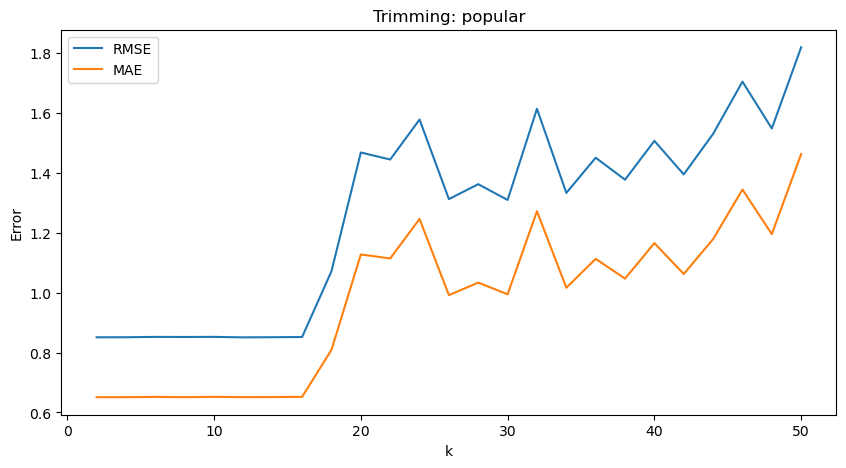

Minimum RMSE:     k     RMSE       MAE
5  12  0.85075  0.651003


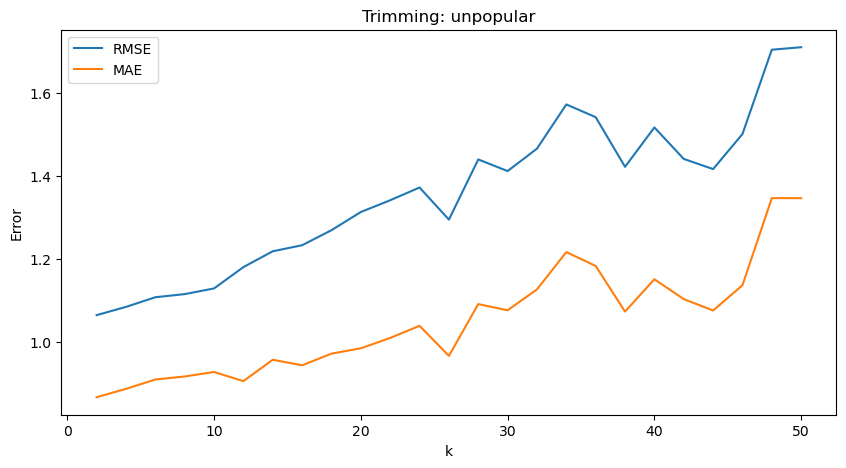

Minimum RMSE:    k      RMSE       MAE
0  2  1.064767  0.866818


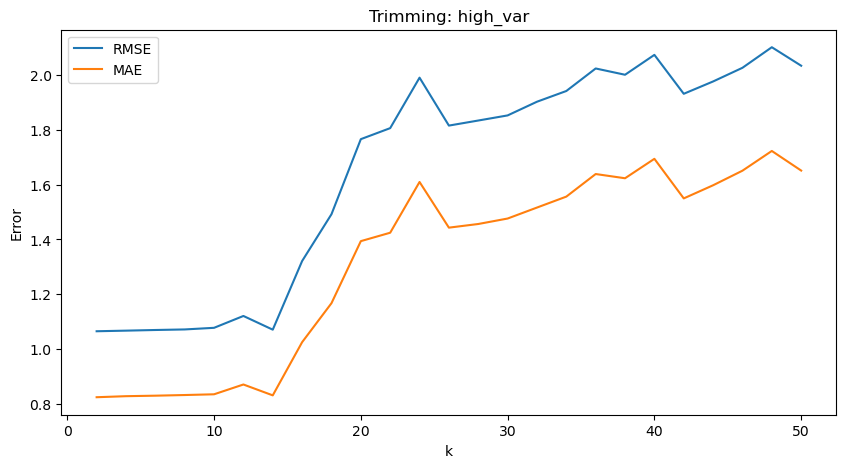

Minimum RMSE:    k      RMSE       MAE
0  2  1.065117  0.824477


In [17]:
# use trimed data
trims = [
    popular_movies_df,
    unpopular_movies_df,
    high_var_movies_df
]

trim_labels = [
    'popular',
    'unpopular',
    'high_var'
]

# ks
k_choices = range(2, 51, 2)

# models
models = [
    NMF(n_factors=k, random_state=0, verbose=False, n_epochs = 50,biased = True)
    for k in k_choices
]

for _itr, trim in enumerate(trims):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(trim[['userId', 'movieId', 'rating']], reader)
    # run the model
    results = []
    for index, model in enumerate(models):
#         print('iteration: {}/{}'.format(index + 1, len(models)))
        result = cross_validate(model, data, cv=kfold, verbose=False, n_jobs=-1)
        results.append(result)
    # get the results
    rmse = [np.mean(result['test_rmse']) for result in results]
    mae = [np.mean(result['test_mae']) for result in results]
    # plot the results
    plt.plot(k_choices, rmse, label='RMSE')
    plt.plot(k_choices, mae, label='MAE')
    plt.xlabel('k')
    plt.ylabel('Error')
    plt.title('Trimming: {}'.format(trim_labels[_itr]))
    plt.legend()
    plt.show()
    # a table, each row is a k, columns are [k, RMSE, MAE]
    table = pd.DataFrame(columns=['k', 'RMSE', 'MAE'])
    table['k'] = k_choices
    table['RMSE'] = rmse
    table['MAE'] = mae
    # minimum rmse
    min_rmse = table.loc[table['RMSE'] == min(table['RMSE'])]
    print('Minimum RMSE: {}'.format(min_rmse))

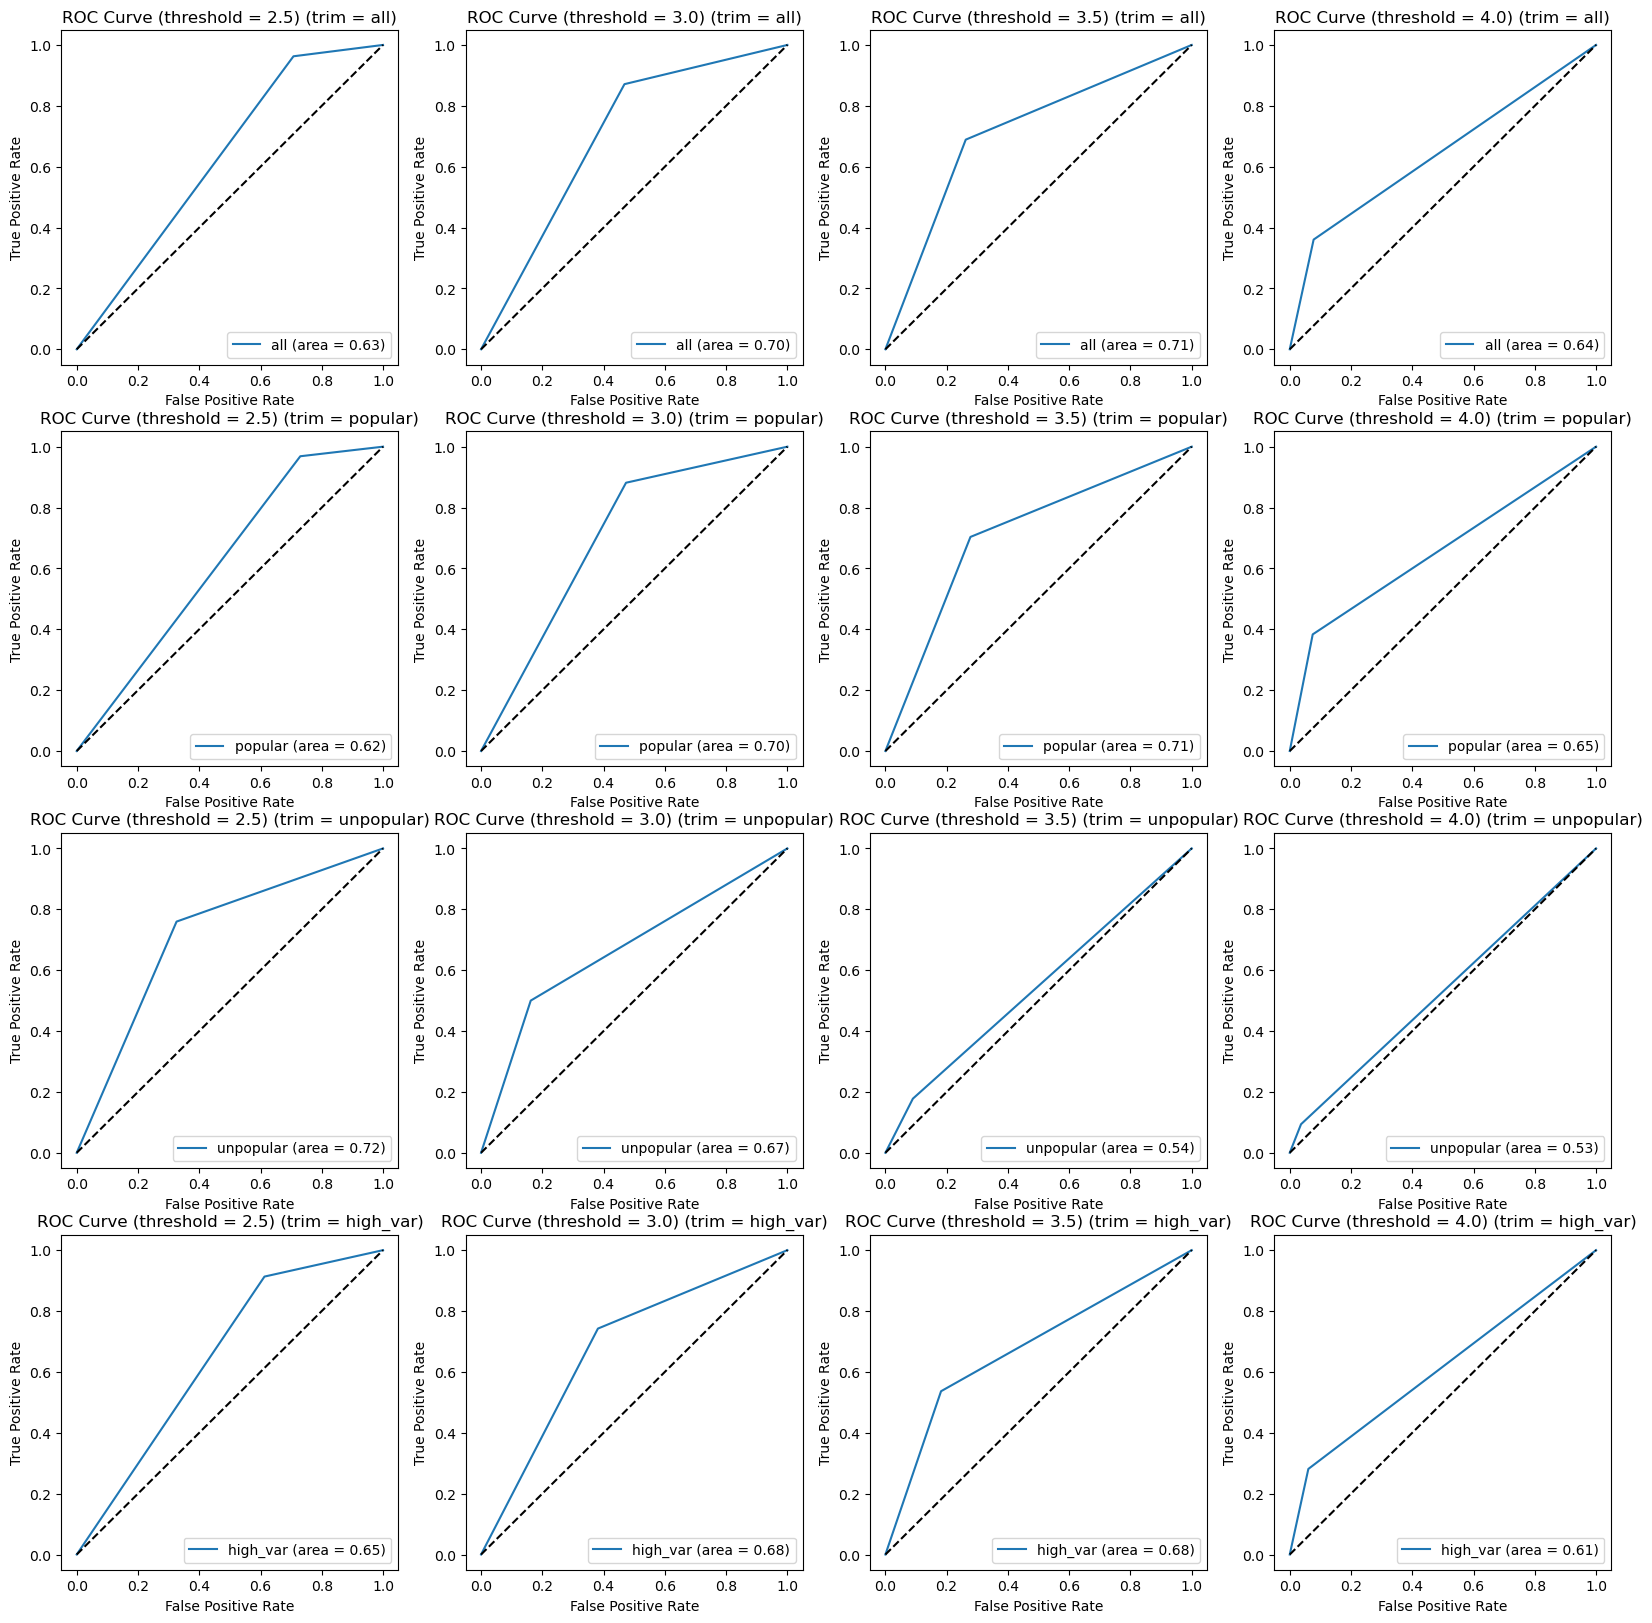

In [18]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
res = []
best_ks = [2, 5, 2, 2]
thresholds = [2.5, 3.0, 3.5, 4.0]

trims = [
  df_ratings,
  popular_movies_df,
  unpopular_movies_df,
  high_var_movies_df
]

trim_labels = [
  'all',
  'popular',
  'unpopular',
  'high_var'
]

for _itr, trim in enumerate(trims):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(trim[['userId', 'movieId', 'rating']], reader)
    # For the ROC plotting, split the dataset into 90% for training and 10% for validation
    trainset, testset = train_test_split(data, test_size=.1)
    # get the model
    model = NMF(n_factors=best_ks[_itr], random_state=0,verbose=False, biased = True)
    model.fit(trainset)

    for threshold in thresholds:
        fpr, tpr, auc_score = get_roc_curve(model, testset, threshold)
        res.append([trim_labels[_itr], threshold, fpr, tpr, auc_score])


# 4*4 plot
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for _itr, r in enumerate(res):
    axs[_itr // 4, _itr % 4].plot(r[2], r[3], label='{} (area = {:.2f})'.format(r[0], r[4]))
    axs[_itr // 4, _itr % 4].plot([0, 1], [0, 1], 'k--')
    axs[_itr // 4, _itr % 4].set_xlabel('False Positive Rate')
    axs[_itr // 4, _itr % 4].set_ylabel('True Positive Rate')
    axs[_itr // 4, _itr % 4].set_title('ROC Curve' + ' (threshold = {})'.format(r[1]) + ' (trim = {})'.format(r[0]))
    axs[_itr // 4, _itr % 4].legend(loc='lower right')
plt.show()

# Question 11

In [ ]:
# naive model

# An important thing to note about the naive collaborative filter is that there is no notion of
# training. For training the model, split the dataset into 10 pairs of train set and validation set
# and for each pair predict the ratings of the movies in the validation set using the prediction
# function (no model fitting required). Then compute the RMSE for this fold and repeat the
# procedure for all the 10 folds. The average RMSE is computed by averaging the RMSE across
# all the 10 folds.

from surprise import AlgoBase

class NaiveColabFilter(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        self.total_mean = {}

        for ur_key in trainset.ur:
            ur = trainset.ur[ur_key]
            mean = np.mean([r for (_, r) in ur])
            self.total_mean[ur_key] = mean


        return self
    
    def estimate(self, u, i):
        if u in self.total_mean:
            return self.total_mean[u]
        else:
            return 0


In [ ]:
model = NaiveColabFilter()

# Design a naive collaborative filter to predict the ratings of the movies in the original dataset
# and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by
# averaging the RMSE across all 10 folds. Report the average RMSE

from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
res = cross_validate(model, data, measures=['RMSE'], cv=10)

# report the average RMSE
print('Average RMSE: {}'.format(np.mean(res['test_rmse'])))



In [ ]:
# subset of the original dataset

for _itr, trim in enumerate(trims):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(trim[['userId', 'movieId', 'rating']], reader)
    res = cross_validate(model, data, measures=['RMSE'], cv=10)
    print('Average RMSE (trim = {}): {}'.format(trim_labels[_itr], np.mean(res['test_rmse'])))

# Question 12

> Comparing the most performant models across architecture: Plot the
best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters
in the same figure. Use the figure to compare the performance of the filters in predicting the ratings
of the movie

In [61]:
KNN_best_k = 42
NMF_best_k = 18
MF_best_k = 2

threshold = 3

In [9]:
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.model_selection import train_test_split

from surprise import Dataset
from surprise import Reader


In [10]:
# KNN with best k
knn_model = KNNBasic(k=KNN_best_k, sim_options={'name': 'pearson'}, verbose=False)
nmf_model = NMF(n_factors=NMF_best_k, random_state=None, verbose=False, n_epochs = 50)
mf_model = NMF(n_factors=MF_best_k, random_state=None, verbose=False, n_epochs = 50, biased = False)

model_names = ['KNN', 'NMF', 'MF with bias']

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
# For the ROC plotting, split the dataset into 90% for training and 10% for validation
trainset, testset = train_test_split(data, test_size=.1)

models = [knn_model, nmf_model, mf_model]
result = []

In [11]:
for model_idx, model in enumerate(models):
    model.fit(trainset)
    fpr, tpr, auc_score = get_roc_curve(model, testset, threshold)
    result.append([model_names[model_idx], fpr, tpr, auc_score])

NameError: name 'get_roc_curve' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


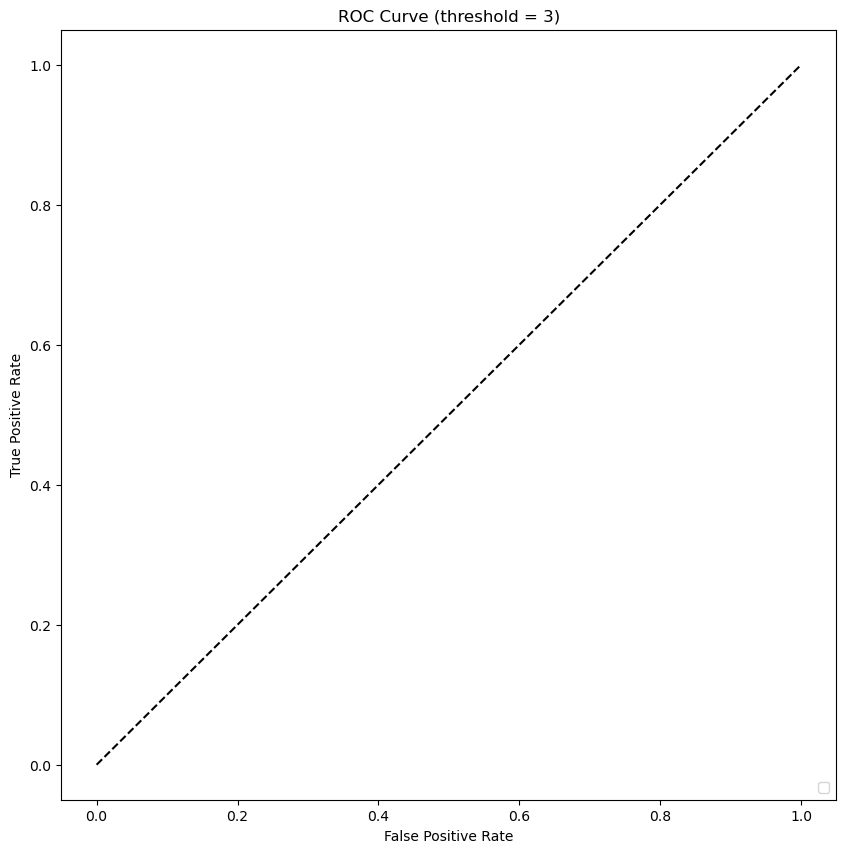

In [12]:
# plot ROC curves on the same plot
fig, ax = plt.subplots(figsize=(10, 10))
for r in result:
    ax.plot(r[1], r[2], label='{} (area = {:.2f})'.format(r[0], r[3]))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve' + ' (threshold = {})'.format(threshold))
ax.legend(loc='lower right')
plt.show()

# Question 13

Answer:

Precision (Refer Formula (12)) is the number of items that were suggested and liked divided by the number of suggestions, it is used to look that our recommendation system is useful to the user or not. A high precision indicates that the system is making accurate recommendations that are tailored to the user's preferences.A low precision means that the system is recommending items that are not relevant to the user, which can lead to frustration and dissatisfaction.

Recall(Refer Formula (13)) is the number of items that were suggested and liked divided by the number of items that were liked, it is used to evaluate how many of the recommendations actually recalled what the user likes.A high recall indicates that the system is able to identify a large proportion of the user's preferences, even if it also recommends some irrelevant items. However, a low recall means that the system is missing some of the user's preferences, which can also lead to dissatisfaction. In the recomendation systems, both Precision and Recall are important.

# Question 14

In [31]:
# KNN with best k
knn_model = KNNBasic(k=KNN_best_k, sim_options={'name': 'pearson'}, verbose=False, random_state=0)
nmf_model = NMF(n_factors=NMF_best_k, random_state=0, verbose=False, n_epochs = 50)
mf_model = NMF(n_factors=MF_best_k, random_state=0, verbose=False, n_epochs = 50, biased = True)

model_names = ['KNN', 'NMF', 'MF with bias']

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
# For the ROC plotting, split the dataset into 90% for training and 10% for validation


models = [knn_model, nmf_model, mf_model]

In [32]:
from collections import defaultdict
def cal_precision_recall(pred, t=5, threshold=3.0):
    user_est_true = defaultdict(list)
    for uid, _, actual_rating, est, _ in pred:
        user_est_true[uid].append((est, actual_rating))
    
    precsicion_dict = dict()
    recall_dict = dict()

    for uid, movie_ratings in user_est_true.items():
        if (len(movie_ratings) >= t):
            movie_ratings.sort(key=lambda x: x[0], reverse=True)
            recc = sum((actual_rating >= threshold) for (_, actual_rating) in movie_ratings)


            if (recc > 0):
                number_of_rec = t
                recc_and_rec_t = sum((actual_rating >= threshold) and (est_r >= threshold) for (est_r, actual_rating) in movie_ratings[:t])
                precsicion_dict[uid] = recc_and_rec_t / number_of_rec
                recall_dict[uid] = recc_and_rec_t / recc

    return precsicion_dict, recall_dict

In [37]:
from surprise.model_selection.split import KFold
import time

time0 = time.time()
ptime0 = time.process_time()

num_splits = 10
kf = KFold(n_splits=num_splits)

knn_precision_each_t = list()
knn_recall_each_t = list()

for t in range(1,26):
    precision_each_fold = list()
    recall_each_fold = list()
    for trainset, testset in kf.split(data):
        knn_model.fit(trainset)
        pred = knn_model.test(testset)
        p, c = cal_precision_recall(pred, t=t, threshold=3.0)
        p = sum(p.values())/len(p)
        c = sum(c.values())/len(c) 
        precision_each_fold.append(p)
        recall_each_fold.append(c)

    knn_precision_each_t.append(sum(precision_each_fold)/num_splits)
    knn_recall_each_t.append(sum(recall_each_fold)/num_splits)

time1 = time.time()
ptime1 = time.process_time()
print('Time:',time1-time0,'CPU time:',ptime1-ptime0)

Time: 183.37397813796997 CPU time: 182.662399


Text(0.5, 1.0, 'Precision Plot for KNN vs. t')

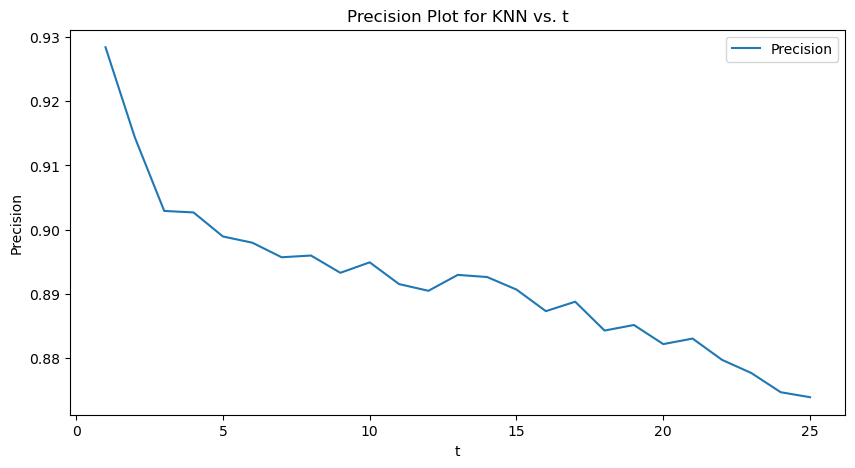

In [50]:
plt.plot(range(1,26), knn_precision_each_t, label = 'Precision')
# plt.plot(range(1,26), recall_each_t, label = 'Recall')
plt.legend()
plt.xlabel('t')
plt.ylabel('Precision')
plt.title('Precision Plot for KNN vs. t')

Text(0.5, 1.0, 'Recall Plot for KNN vs. t')

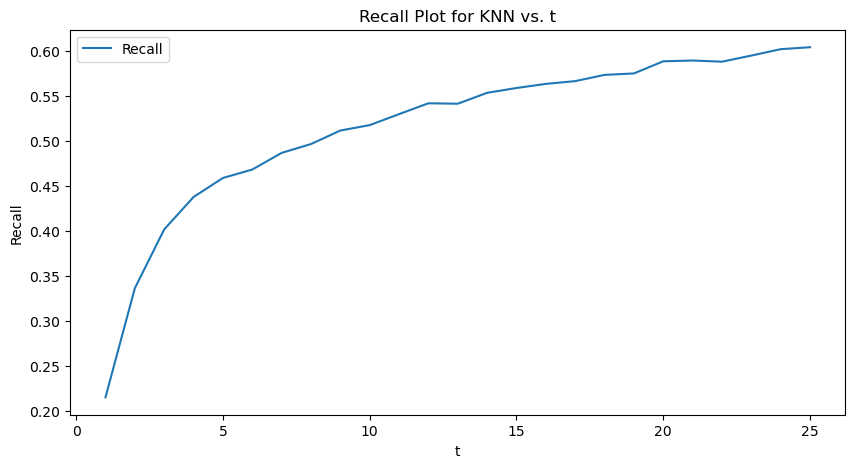

In [39]:
# plt.plot(range(1,26), precision_each_t, label = 'Precision')
plt.plot(range(1,26), knn_recall_each_t, label = 'Recall')
plt.legend()
plt.xlabel('t')
plt.ylabel('Recall')
plt.title('Recall Plot for KNN vs. t')

Text(0.5, 1.0, 'Precision vs. Recall Plot')

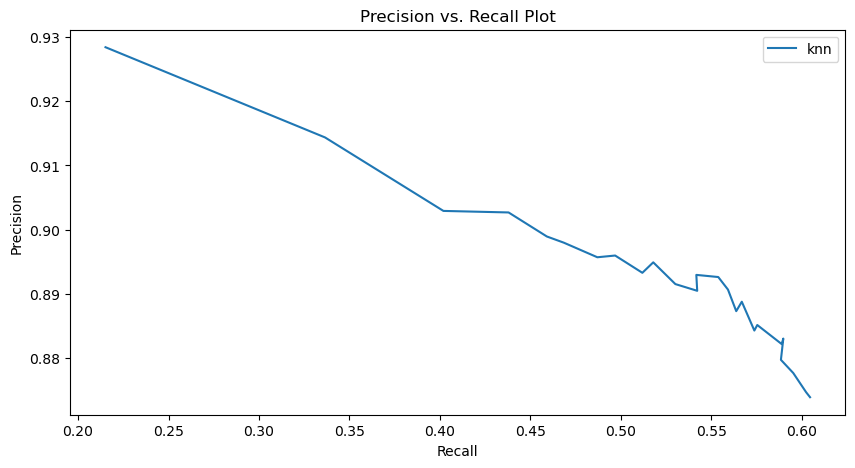

In [40]:
plt.plot(knn_recall_each_t,knn_precision_each_t, label = 'knn')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Plot')

In [41]:
#NMF
from surprise.model_selection.split import KFold
import time

time0 = time.time()
ptime0 = time.process_time()


nmf_precision_each_t = list()
nmf_recall_each_t = list()

for t in range(1,26):
    precision_each_fold = list()
    recall_each_fold = list()
    for trainset, testset in kf.split(data):
        nmf_model.fit(trainset)
        pred = nmf_model.test(testset)
        p, c = cal_precision_recall(pred, t=t, threshold=3.0)
        p = sum(p.values())/len(p)
        c = sum(c.values())/len(c) 
        precision_each_fold.append(p)
        recall_each_fold.append(c)

    nmf_precision_each_t.append(sum(precision_each_fold)/num_splits)
    nmf_recall_each_t.append(sum(recall_each_fold)/num_splits)
#     print('t=',t,'completed')

time1 = time.time()
ptime1 = time.process_time()
print('Time:',time1-time0,'CPU time:',ptime1-ptime0)

Time: 445.11418318748474 CPU time: 443.68167800000003


Text(0.5, 1.0, 'Precisio Plot for NMF vs. t')

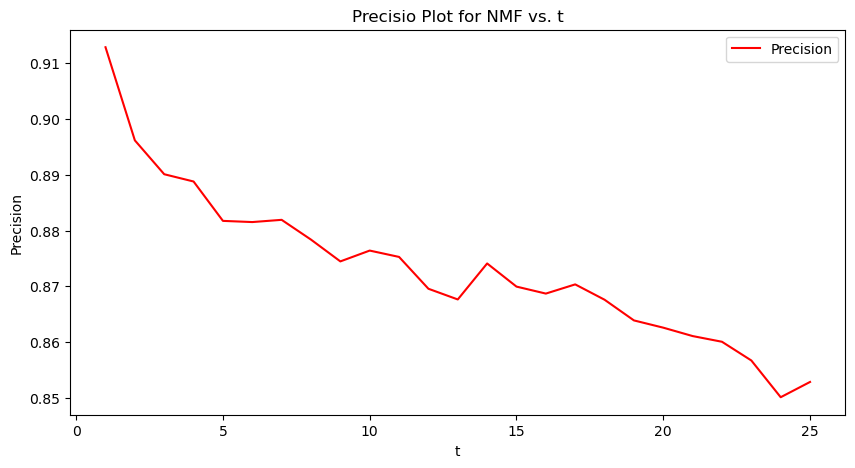

In [42]:
plt.plot(range(1,26), nmf_precision_each_t, label = 'Precision', color = 'r')
# plt.plot(range(1,26), recall_each_t, label = 'Recall')
plt.legend()
plt.xlabel('t')
plt.ylabel('Precision')
plt.title('Precisio Plot for NMF vs. t')

Text(0.5, 1.0, 'Recall Plot for NMF vs. t')

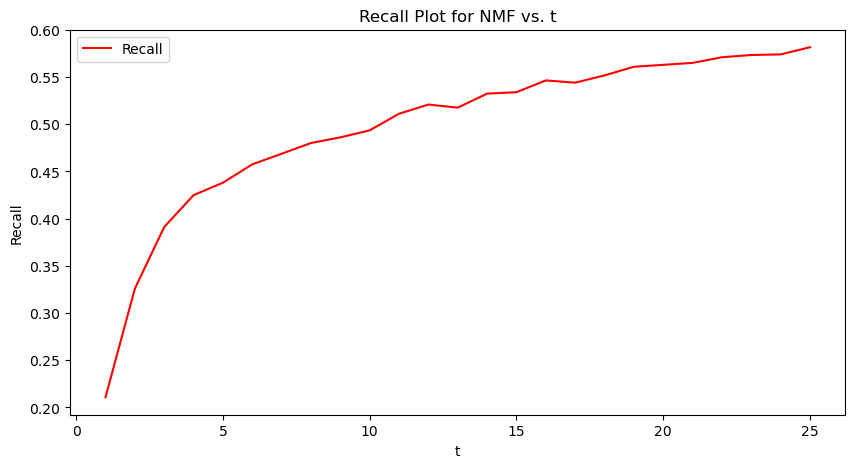

In [43]:
plt.plot(range(1,26), nmf_recall_each_t, label = 'Recall', color = 'r')
plt.legend()
plt.xlabel('t')
plt.ylabel('Recall')
plt.title('Recall Plot for NMF vs. t')

Text(0.5, 1.0, 'Precision vs. Recall Plot')

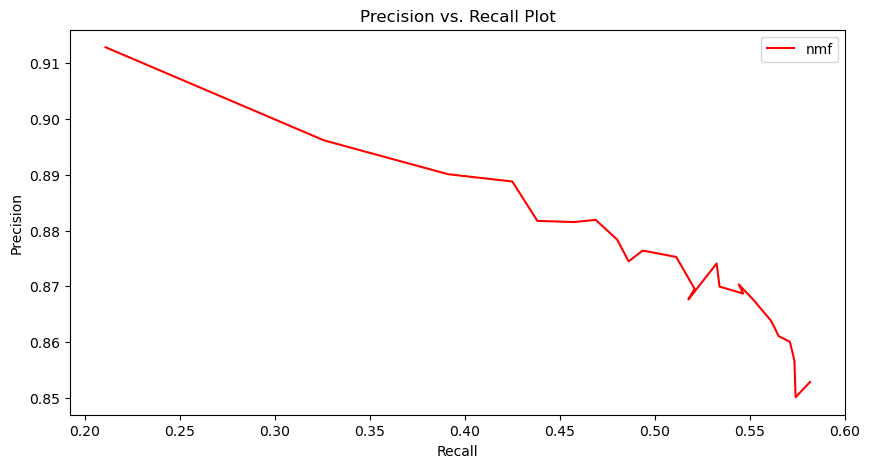

In [44]:
plt.plot(nmf_recall_each_t,nmf_precision_each_t, label = 'nmf', color = 'r')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Plot')

In [45]:
from surprise.model_selection.split import KFold
import time

time0 = time.time()
ptime0 = time.process_time()


mf_precision_each_t = list()
mf_recall_each_t = list()

for t in range(1,26):
    precision_each_fold = list()
    recall_each_fold = list()
    for trainset, testset in kf.split(data):
        mf_model.fit(trainset)
        pred = mf_model.test(testset)
        p, c = cal_precision_recall(pred, t=t, threshold=3.0)
        p = sum(p.values())/len(p)
        c = sum(c.values())/len(c) 
        precision_each_fold.append(p)
        recall_each_fold.append(c)
    
    
    mf_precision_each_t.append(sum(precision_each_fold)/10)
    mf_recall_each_t.append(sum(recall_each_fold)/10)
#     print('t=',t,'completed')

time1 = time.time()
ptime1 = time.process_time()
print('Time:',time1-time0,'CPU time:',ptime1-ptime0)

Time: 256.71459674835205 CPU time: 256.19454199999996


Text(0.5, 1.0, 'Precisio Plot for MF vs. t')

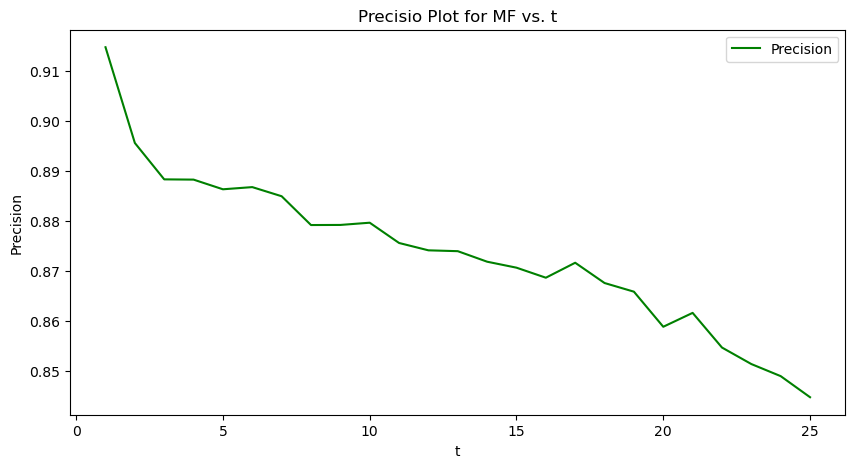

In [46]:
plt.plot(range(1,26), mf_precision_each_t, label = 'Precision', color = 'g')
# plt.plot(range(1,26), recall_each_t, label = 'Recall')
plt.legend()
plt.xlabel('t')
plt.ylabel('Precision')
plt.title('Precisio Plot for MF vs. t')

Text(0.5, 1.0, 'Recall Plot for MF vs. t')

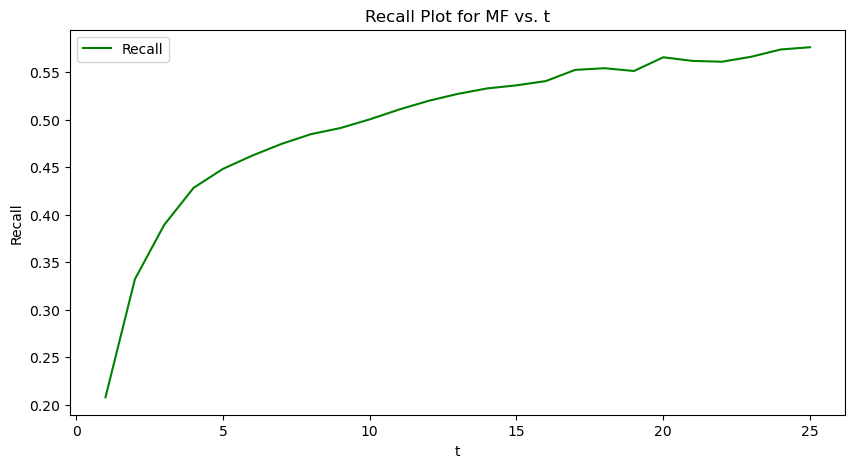

In [47]:
plt.plot(range(1,26), mf_recall_each_t, label = 'Recall', color = 'g')
plt.legend()
plt.xlabel('t')
plt.ylabel('Recall')
plt.title('Recall Plot for MF vs. t')

Text(0.5, 1.0, 'Precision vs. Recall Plot')

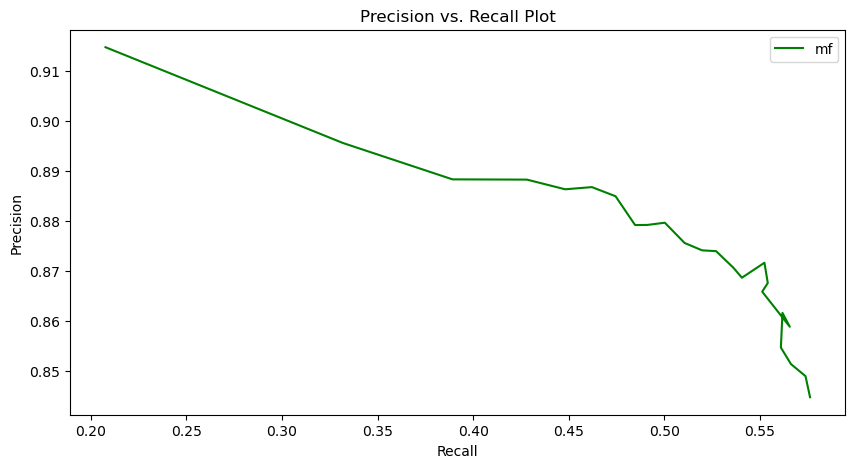

In [48]:
plt.plot(mf_recall_each_t,mf_precision_each_t, label = 'mf', color = 'g')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Plot')

Text(0.5, 1.0, 'Precision vs. Recall Plot')

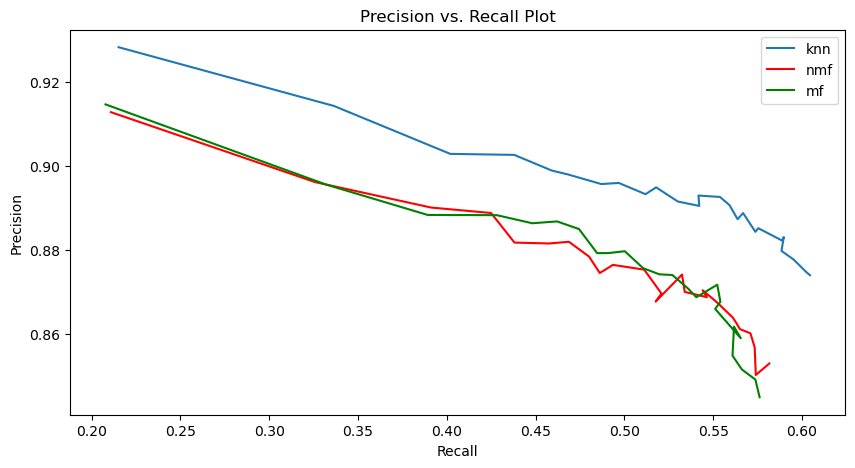

In [49]:
plt.plot(knn_recall_each_t,knn_precision_each_t, label = 'knn')
plt.plot(nmf_recall_each_t,nmf_precision_each_t, label = 'nmf', color = 'r')
plt.plot(mf_recall_each_t,mf_precision_each_t, label = 'mf', color = 'g')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Plot')

In [65]:
t_range = range(1, 26)

In [66]:
def cal_precision_recall(pred, threshold=3.0):
    df_pred = pd.DataFrame(np.array(pred))
    precision_list = list()
    recall_list = list()
    
    for t in t_range:
        precision = list()
        recall = list()
        for user in np.unique(df_pred[0]):
            df_pred_slice = df_pred[df_pred[0] == user]
            t_max = len(df_pred_slice[2][df_pred_slice[2] >= threshold])
            ground_truth_list = np.array(df_pred_slice[1][df_pred_slice[2] >= threshold])
            if t <= t_max:
                recom_list = np.array(df_pred_slice.sort_values(by=[3], ascending=False)[1][0:t])
                S_t = 1.0*len(np.intersect1d(ground_truth_list, recom_list)) / t
                G = 1.0*len(np.intersect1d(ground_truth_list, recom_list)) / len(ground_truth_list)

                precision.append(S_t)
                recall.append(G)
            else:
                pass
        precision_list.append(np.mean(precision))
        recall_list.append(np.mean(recall))
    return precision_list, recall_list

def get_prediction(model, trainset, testset):
    model.fit(trainset)
    pred = model.test(testset)
    return pred

In [67]:
from surprise.model_selection import KFold
from surprise import Dataset
from surprise import Reader
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.knns import KNNBasic

# KNN with best k
knn_model = KNNBasic(k=KNN_best_k, sim_options={'name': 'pearson'}, verbose=False, random_state=0)
nmf_model = NMF(n_factors=NMF_best_k, random_state=0, verbose=False, n_epochs = 50)
mf_model = NMF(n_factors=MF_best_k, random_state=0, verbose=False, n_epochs = 50, biased = True)
kf = KFold(n_splits=10, random_state=0)

model_names = ['KNN', 'NMF', 'MF with bias']

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
# For the ROC plotting, split the dataset into 90% for training and 10% for validation


models = [knn_model, nmf_model, mf_model]

In [68]:
total_res = []

for model_idx, model in enumerate(models):
    precision_list = np.zeros((1, len(t_range)))

    recall_list = np.zeros((1, len(t_range)))
    for trainset, testset in kf.split(data):
        pred = get_prediction(model, trainset, testset)
        precision, recall = cal_precision_recall(pred, threshold)
        precision_list += np.array(precision)
        recall_list += np.array(recall)
    precision_list = precision_list / 10
    recall_list = recall_list / 10
    # precision - t plot
    total_res.append([model_names[model_idx], precision_list, recall_list])


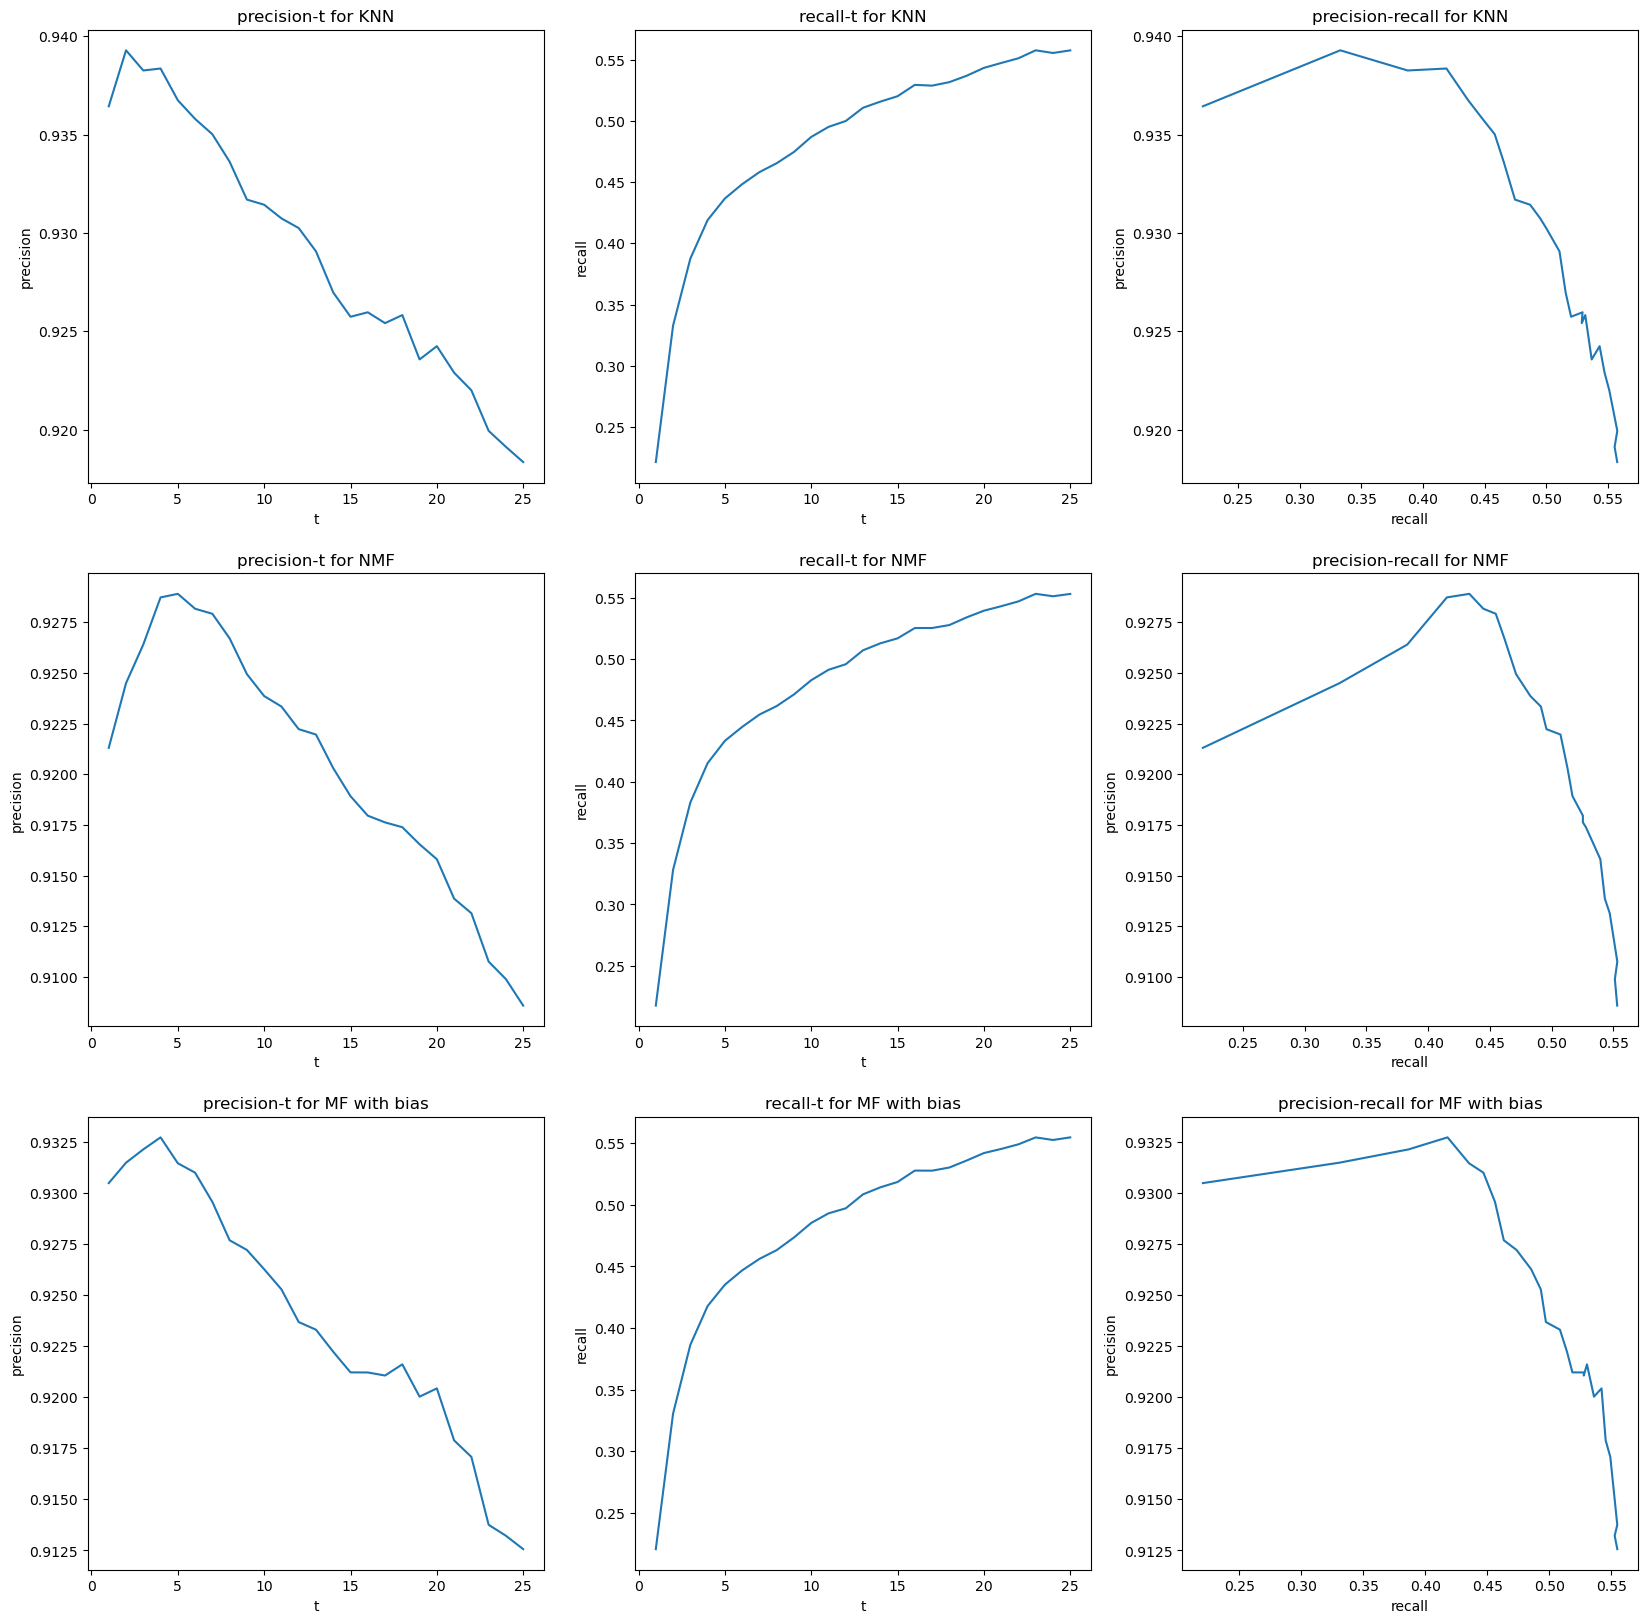

In [69]:
# 3*3 plot, each model has 3 plots: precision-t, recall-t, precision-recall
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for i in range(3):
    for j in range(3):
        if j == 0:
            ax[i, j].plot(t_range, total_res[i][1][0], label='precision')
            ax[i, j].set_title('precision-t for {}'.format(total_res[i][0]))
            ax[i, j].set_xlabel('t')
            ax[i, j].set_ylabel('precision')
        elif j == 1:
            ax[i, j].plot(t_range, total_res[i][2][0], label='recall')
            ax[i, j].set_title('recall-t for {}'.format(total_res[i][0]))
            ax[i, j].set_xlabel('t')
            ax[i, j].set_ylabel('recall')
        else:
            ax[i, j].plot(total_res[i][2][0], total_res[i][1][0], label='precision-recall')
            ax[i, j].set_title('precision-recall for {}'.format(total_res[i][0]))
            ax[i, j].set_xlabel('recall')
            ax[i, j].set_ylabel('precision')
plt.show()


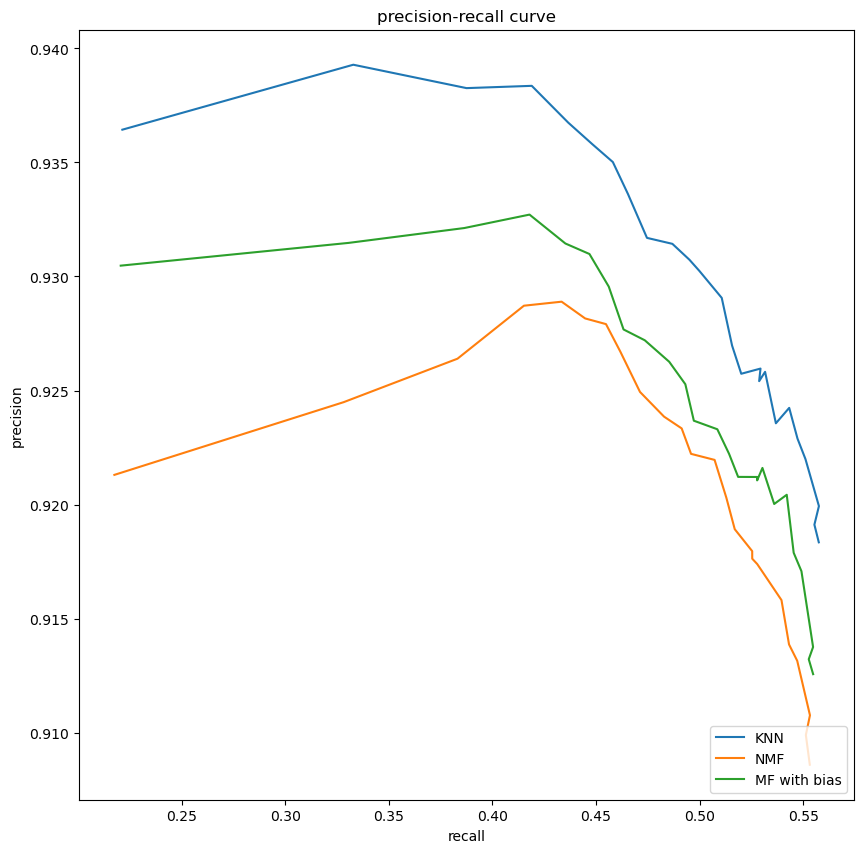

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))
for r in total_res:
    ax.plot(r[2][0], r[1][0], label='{}'.format(r[0]))
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.set_title('precision-recall curve')
ax.legend(loc='lower right')
plt.show()